<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***30% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on a sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# UDFs
from py.utils import load_and_filter_data, load_tickers
from py.optimal_portfolio import select_diversified_portfolio, calculate_min_variance_portfolio, plot_efficient_frontier_interactive, plot_portfolio_weights

# System libraries
import glob
import os
from typing import Dict, List
from dotenv import load_dotenv
load_dotenv()

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image, display

# Backtesting library
import bt

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

In [2]:
# API Requests
import logging
import requests
from requests.adapters import HTTPAdapter
from concurrent.futures import ThreadPoolExecutor
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# Create logger instance
logger = logging.getLogger(__name__)

def create_session():
    """Create a requests session with retry configuration"""
    session = requests.Session()
    retries = Retry(
        total=3,
        backoff_factor=1,
        status_forcelist=[429, 500, 502, 503, 504]
    )
    session.mount('https://', HTTPAdapter(max_retries=retries, pool_maxsize=10))
    return session

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=1*365)            # 1 year before the end date

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2024-05-30 to 2025-05-30
Time span: 365 days (1.00 years)


#### Portfolio Constraints

In [4]:
min_assets = 5                  # Minimum number of assets to include in the portfolio
max_assets = 100                # Maximum number of assets to include in the portfolio  
max_asset_per_sector = 2        # Maximum Asset per sector
max_allocation_weight = 0.3     # Maximum allocation for each asset
min_allocation_weight = 0.05    # Minimum allocation weight for included assets

#### Risk-free rate (T-bill, %)

In [5]:
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042249999999999996 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [6]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-05-28.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [7]:
def fetch_data(api_key: str, session: requests.Session) -> Dict:
    """Fetch stock news for the entire week (7 days) with pagination"""
    # Calculate date range for the entire week
    today = datetime.now().date()
    week_ago = today - timedelta(days=7)
    
    all_data = []
    
    # Loop through 10 pages with 1000 records each
    for page in range(10):
        url = f"https://financialmodelingprep.com/api/v3/stock_news"
        params = {
            "apikey": api_key,
            "from": week_ago.strftime('%Y-%m-%d'),
            "to": today.strftime('%Y-%m-%d'),
            "limit": 1000,
            "page": page
        }
        
        try:
            print(f"Fetching page {page + 1}/10...")
            response = session.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            
            if not data:  # If no more data, break the loop
                print(f"No more data found at page {page + 1}. Stopping pagination.")
                break
                
            all_data.extend(data)
            print(f"Page {page + 1}: {len(data)} articles fetched")
            
        except Exception as e:
            print(f"Error fetching page {page + 1}: {e}")
            continue
    
    print(f"Total articles fetched: {len(all_data)}")
    return all_data

# Create a session
session = create_session()

# Execute fetching
data = fetch_data(FMP_API_KEY, session)

# Convert to Polars DataFrame if data exists and filter for recent dates
if data:
    df = pl.DataFrame(data)
    
    # Filter for news from the last week to ensure we get comprehensive coverage
    today = datetime.now().date()
    week_ago = today - timedelta(days=7)
    
    # Convert publishedDate to date for filtering
    df = df.with_columns([
        pl.col("publishedDate").str.strptime(pl.Date, format="%Y-%m-%d %H:%M:%S").alias("published_date")
    ])
    
    # Filter for last week
    df = df.filter(pl.col("published_date") >= week_ago)
    
    print(f"Final dataset: {len(df)} news articles from {week_ago} to {today} (7 days)")
    
    # Optional: Show distribution by day
    daily_counts = df.group_by("published_date").agg(pl.count().alias("article_count")).sort("published_date")
    print("\nDaily article distribution:")
    for row in daily_counts.iter_rows():
        print(f"{row[0]}: {row[1]} articles")
    
else:
    df = pl.DataFrame()
    print("No data fetched")

display(df.head(10))

Fetching page 1/10...
Page 1: 1000 articles fetched
Fetching page 2/10...
Page 2: 1000 articles fetched
Fetching page 3/10...
Page 3: 999 articles fetched
Fetching page 4/10...
Page 4: 1000 articles fetched
Fetching page 5/10...
Page 5: 996 articles fetched
Fetching page 6/10...
Page 6: 1000 articles fetched
Fetching page 7/10...
Page 7: 1000 articles fetched
Fetching page 8/10...
Page 8: 1000 articles fetched
Fetching page 9/10...
Page 9: 1000 articles fetched
Fetching page 10/10...
Page 10: 858 articles fetched
Total articles fetched: 9853
Final dataset: 9853 news articles from 2025-05-24 to 2025-05-31 (7 days)

Daily article distribution:
2025-05-24: 287 articles
2025-05-25: 433 articles
2025-05-26: 892 articles
2025-05-27: 2108 articles
2025-05-28: 2263 articles
2025-05-29: 2143 articles
2025-05-30: 1521 articles
2025-05-31: 206 articles


/tmp/ipykernel_184402/55778234.py:65: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  daily_counts = df.group_by("published_date").agg(pl.count().alias("article_count")).sort("published_date")


symbol,publishedDate,title,image,site,text,url,published_date
str,str,str,str,str,str,str,date
"""CAR""","""2025-05-31 13:21:00""","""ROSEN, GLOBAL INVESTOR COUNSEL…","""https://images.financialmodeli…","""globenewswire.com""","""NEW YORK, May 31, 2025 (GLOBE …","""https://www.globenewswire.com/…",2025-05-31
"""CGC""","""2025-05-31 13:13:00""","""CGC IMPORTANT DEADLINE: ROSEN,…","""https://images.financialmodeli…","""globenewswire.com""","""NEW YORK, May 31, 2025 (GLOBE …","""https://www.globenewswire.com/…",2025-05-31
"""GM""","""2025-05-31 13:07:00""","""BIOSIG TECHNOLOGIES INVESTOR A…","""https://images.financialmodeli…","""businesswire.com""","""NEW YORK & NEW ORLEANS--(BUSIN…","""https://www.businesswire.com/n…",2025-05-31
"""BKKT""","""2025-05-31 13:05:00""","""SHAREHOLDER REMINDER: Faruqi &…","""https://images.financialmodeli…","""prnewswire.com""","""Faruqi & Faruqi, LLP Securitie…","""https://www.prnewswire.com/new…",2025-05-31
"""MYBUF""","""2025-05-31 13:01:53""","""Swiss solar panel maker Meyer …","""https://images.financialmodeli…","""reuters.com""","""Swiss solar panel maker Meyer …","""https://www.reuters.com/market…",2025-05-31
"""AMZN""","""2025-05-31 13:00:20""","""Tech Corner: AMZN""","""https://images.financialmodeli…","""youtube.com""","""While Amazon (AMZN) is known p…","""https://www.youtube.com/watch?…",2025-05-31
"""GM""","""2025-05-31 12:30:00""","""HELIOGEN INVESTOR ALERT by the…","""https://images.financialmodeli…","""businesswire.com""","""NEW YORK & NEW ORLEANS--(BUSIN…","""https://www.businesswire.com/n…",2025-05-31
"""BBAI""","""2025-05-31 12:22:00""","""BBAI DEADLINE: ROSEN, GLOBAL I…","""https://images.financialmodeli…","""globenewswire.com""","""NEW YORK, May 31, 2025 (GLOBE …","""https://www.globenewswire.com/…",2025-05-31
"""KEX""","""2025-05-31 12:11:53""","""United Airlines CEO Scott Kirb…","""https://images.financialmodeli…","""businessinsider.com""","""United Airlines CEO Scott Kirb…","""https://www.businessinsider.co…",2025-05-31


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [8]:
# Import additional libraries for sentiment analysis
from textblob import TextBlob
import re
from collections import defaultdict

# ===============================================================================
# DATA LOADING & PREPARATION
# ===============================================================================

print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')

print(f"Loaded fundamental data for {len(fundamentals_df)} stocks")

# Combine ticker lists for comprehensive analysis
news_tickers = df['symbol'].to_list()
fundamental_tickers = fundamentals_df['Ticker'].to_list()
all_tickers = set(news_tickers + fundamental_tickers)

print(f"News tickers: {len(news_tickers)}")
print(f"Fundamental tickers: {len(fundamental_tickers)}")
print(f"Combined unique tickers: {len(all_tickers)}")

# ===============================================================================
# SENTIMENT ANALYSIS FUNCTIONS
# ===============================================================================

# Filter out common words that might be misidentified as stock symbols
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

def extract_stock_symbols(text):
    """Extract valid stock symbols from text, excluding common words"""
    symbols = re.findall(r'\b[A-Z]{1,5}\b', text)
    return [symbol for symbol in symbols 
            if symbol in all_tickers and symbol not in EXCLUDED_SYMBOLS]

def analyze_sentiment(text):
    """Analyze sentiment using TextBlob and classify as bullish/bearish/neutral"""
    polarity = TextBlob(text).sentiment.polarity
    
    if polarity > 0.1:
        return 'bullish', polarity
    elif polarity < -0.1:
        return 'bearish', polarity
    else:
        return 'neutral', polarity

def calculate_stock_sentiment_metrics(df):
    """Calculate comprehensive sentiment metrics for each stock symbol"""
    stock_metrics = defaultdict(lambda: {
        'sentiment_scores': [],
        'bullish_count': 0,
        'bearish_count': 0,
        'neutral_count': 0,
        'total_articles': 0
    })
    
    # Process each news article
    for row in df.iter_rows(named=True):
        full_text = f"{row.get('title', '')} {row.get('text', '')}"
        mentioned_symbols = extract_stock_symbols(full_text)
        sentiment_type, sentiment_score = analyze_sentiment(full_text)
        
        # Update metrics for each mentioned symbol
        for symbol in mentioned_symbols:
            metrics = stock_metrics[symbol]
            metrics['sentiment_scores'].append(sentiment_score)
            metrics['total_articles'] += 1
            metrics[f'{sentiment_type}_count'] += 1
    
    # Calculate final metrics
    final_metrics = {}
    for symbol, data in stock_metrics.items():
        if data['total_articles'] > 0:
            total = data['total_articles']
            avg_sentiment = sum(data['sentiment_scores']) / len(data['sentiment_scores'])
            
            final_metrics[symbol] = {
                "articlesInLastWeek": total,
                "companyNewsScore": round((avg_sentiment + 1) / 2, 4),
                "sentiment": {
                    "bearishPercent": round(data['bearish_count'] / total, 4),
                    "bullishPercent": round(data['bullish_count'] / total, 4)
                },
                "averageSentimentScore": round(avg_sentiment, 4),
                "totalArticles": total
            }
    
    return final_metrics

# ===============================================================================
# SENTIMENT ANALYSIS EXECUTION
# ===============================================================================

print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(df)

print(f"Excluded symbols: {EXCLUDED_SYMBOLS}")
print(f"Valid symbols found: {len(sentiment_metrics)}")

# Create sentiment DataFrame (removed buzz and weeklyAverage columns)
sentiment_df = pl.DataFrame([
    {
        "symbol": symbol,
        "articlesInLastWeek": metrics["articlesInLastWeek"],
        "companyNewsScore": metrics["companyNewsScore"],
        "bearishPercent": metrics["sentiment"]["bearishPercent"],
        "bullishPercent": metrics["sentiment"]["bullishPercent"],
        "averageSentimentScore": metrics["averageSentimentScore"],
        "totalArticles": metrics["totalArticles"]
    }
    for symbol, metrics in sentiment_metrics.items()
]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

print(f"\nSentiment analysis completed for {len(sentiment_df)} stocks")
print("Top 10 most mentioned stocks:")
display(sentiment_df.head(10))

# ===============================================================================
# SECTOR ANALYSIS & FUNDAMENTAL DATA INTEGRATION
# ===============================================================================

def calculate_sector_averages(sentiment_df, fundamentals_pandas):
    """Calculate sector-level sentiment averages"""
    sector_metrics = defaultdict(list)
    
    for row in sentiment_df.iter_rows(named=True):
        symbol = row['symbol']
        if symbol in fundamentals_pandas.index:
            sector = fundamentals_pandas.loc[symbol, 'Sector']
            sector_metrics[sector].append({
                'bullishPercent': row['bullishPercent'],
                'newsScore': row['companyNewsScore']
            })
    
    return {
        sector: {
            'sectorAverageBullishPercent': round(sum(m['bullishPercent'] for m in metrics) / len(metrics), 4),
            'sectorAverageNewsScore': round(sum(m['newsScore'] for m in metrics) / len(metrics), 4)
        }
        for sector, metrics in sector_metrics.items() if metrics
    }

def get_fundamental_value(symbol, column, default=0):
    """Safely get fundamental data value for a symbol"""
    return fundamentals_pandas.loc[symbol, column] if symbol in fundamentals_pandas.index else default

# Calculate sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
print(f"\nSector averages calculated for {len(sector_averages)} sectors")

# Add fundamental data to sentiment DataFrame
sentiment_with_fundamentals = sentiment_df.with_columns([
    # Sector averages
    pl.col("symbol").map_elements(
        lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0),
        return_dtype=pl.Float64
    ).alias("sectorAverageBullishPercent"),
    
    pl.col("symbol").map_elements(
        lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0),
        return_dtype=pl.Float64
    ).alias("sectorAverageNewsScore"),
    
    # Fundamental metrics (removed dividendYield)
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

print("\nSentiment data combined with fundamental data:")
display(sentiment_with_fundamentals.head(10))

# ===============================================================================
# STOCK SCREENING & ANALYSIS
# ===============================================================================

# Apply sentiment-based screening only (no fundamental criteria)
comprehensive_screened = sentiment_with_fundamentals.filter(
    # Sentiment criteria only
    (pl.col("articlesInLastWeek") >= 3) &
    (pl.col("companyNewsScore") >= 0.45)
).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])

print(f"\nSentiment-based screening results: {len(comprehensive_screened)} stocks")
print("Top 15 stocks meeting sentiment criteria:")
display(comprehensive_screened.head(15))

# Sector analysis summary
sector_summary = sentiment_with_fundamentals.filter(
    pl.col("sector") != "Unknown"
).group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"),
    pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"),
    pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print("\nSector Analysis (by average news sentiment):")
display(sector_summary)

# ===============================================================================
# RESULTS & EXPORT
# ===============================================================================

# Save results
print("\nSaving analysis results...")
sentiment_with_fundamentals.write_csv("data/combined_sentiment_fundamentals.csv")
comprehensive_screened.write_csv("data/screened_stocks.csv")
print("Files saved: combined_sentiment_fundamentals.csv and screened_stocks.csv")

Loading fundamental data...
Loaded fundamental data for 504 stocks
News tickers: 9853
Fundamental tickers: 504
Combined unique tickers: 3407
Analyzing sentiment for stock symbols...
Excluded symbols: {'A', 'C', 'S', 'AI', 'E', 'TSXV', 'US', 'U', 'ET', 'CODI'}
Valid symbols found: 2745

Sentiment analysis completed for 2745 stocks
Top 10 most mentioned stocks:


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles
str,i64,f64,f64,f64,f64,i64
"""NVDA""",175,0.5497,0.0857,0.4343,0.0995,175
"""V""",167,0.5432,0.024,0.3593,0.0865,167
"""D""",163,0.565,0.0245,0.5337,0.1299,163
"""VTRS""",156,0.5588,0.0192,0.5513,0.1175,156
"""OGN""",151,0.5503,0.0397,0.5033,0.1006,151
"""CIVI""",146,0.5635,0.0137,0.6233,0.1271,146
"""IOVA""",146,0.5557,0.0137,0.5068,0.1114,146
"""AM""",143,0.6519,0.0,0.8252,0.3038,143
"""BBAI""",140,0.5661,0.0,0.6357,0.1322,140



Sector averages calculated for 11 sectors

Sentiment data combined with fundamental data:


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""NVDA""",175,0.5497,0.0857,0.4343,0.0995,175,0.5672,0.5757,"""Technology""",3.4116e12,47.58,139.89
"""V""",167,0.5432,0.024,0.3593,0.0865,167,0.3882,0.5556,"""Financial Services""",6.9194e11,36.27,361.2
"""D""",163,0.565,0.0245,0.5337,0.1299,163,0.6583,0.6078,"""Utilities""",4.7432e10,21.47,55.62
"""VTRS""",156,0.5588,0.0192,0.5513,0.1175,156,0.5927,0.5837,"""Healthcare""",1.0217e10,NaN,8.7
"""OGN""",151,0.5503,0.0397,0.5033,0.1006,151,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""CIVI""",146,0.5635,0.0137,0.6233,0.1271,146,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""IOVA""",146,0.5557,0.0137,0.5068,0.1114,146,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""AM""",143,0.6519,0.0,0.8252,0.3038,143,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BBAI""",140,0.5661,0.0,0.6357,0.1322,140,0.0,0.0,"""Unknown""",0.0,0.0,0.0



Sentiment-based screening results: 1202 stocks
Top 15 stocks meeting sentiment criteria:


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BGM""",4,0.9,0.0,1.0,0.8,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""CART""",3,0.8167,0.0,1.0,0.6333,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BBY""",19,0.8084,0.0,1.0,0.6167,19,0.4488,0.5652,"""Consumer Cyclical""",1.3848e10,15.29,65.42
"""CYBR""",3,0.7833,0.0,1.0,0.5667,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""NSCIF""",3,0.7803,0.0,1.0,0.5606,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…
"""MGMNF""",4,0.748,0.0,1.0,0.496,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""LRCX""",6,0.7475,0.0,1.0,0.495,6,0.5672,0.5757,"""Technology""",1.0734e11,23.38,83.92
"""SSRM""",3,0.7456,0.0,1.0,0.4911,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0



Sector Analysis (by average news sentiment):


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Utilities""",27,0.607752,0.658274,12.444444,4.2513e10,20.598148
"""Healthcare""",48,0.583719,0.592706,14.229167,9.5240e10,NaN
"""Technology""",73,0.575704,0.567238,12.0,2.2656e11,NaN
"""Communication Services""",19,0.569563,0.525547,16.052632,3.9629e11,NaN
"""Industrials""",54,0.5687,0.512789,7.537037,6.0410e10,NaN
…,…,…,…,…,…,…
"""Energy""",21,0.5598,0.413943,4.761905,7.0078e10,NaN
"""Consumer Defensive""",26,0.558158,0.507204,12.423077,1.1667e11,NaN
"""Financial Services""",55,0.555565,0.388158,8.581818,1.0622e11,NaN



Saving analysis results...
Files saved: combined_sentiment_fundamentals.csv and screened_stocks.csv


### Step 5: Select 10 stocks by sentiment score (bullish and bearish)
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [9]:
# Load long-term portfolio and extract tickers for exclusion
long_term_portfolio = pl.read_excel(output_file, sheet_name='long_term_portfolio')
long_term_tickers = long_term_portfolio['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

# Select top 50 stocks by averageSentimentScore
def get_top_sentiment_stocks():
    """Get top 50 stocks with highest averageSentimentScore"""
    return (comprehensive_screened
        .filter(pl.col("sector") != 'Unknown')
        .filter(~pl.col("symbol").is_in(long_term_tickers))
        .sort("averageSentimentScore", descending=True)
        .head(100))

# Get top 50 stocks with highest average sentiment scores
print("\nTop 50 stocks with highest averageSentimentScore:")
selected_stocks = get_top_sentiment_stocks()
display(selected_stocks.head(20))  # Display first 20 for readability

# Extract ticker list for further analysis
screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks for portfolio optimization")

# Show sector distribution of selected stocks
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution of selected {len(screened_tickers)} stocks:")
display(sector_distribution)

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['PH', 'TMUS', 'MMC', 'GS', 'SO']

Top 50 stocks with highest averageSentimentScore:


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BBY""",19,0.8084,0.0,1.0,0.6167,19,0.4488,0.5652,"""Consumer Cyclical""",1.3848e10,15.29,65.42
"""LRCX""",6,0.7475,0.0,1.0,0.495,6,0.5672,0.5757,"""Technology""",1.0734e11,23.38,83.92
"""FI""",4,0.7242,0.0,0.75,0.4484,4,0.5672,0.5757,"""Technology""",8.8477e10,28.29,159.58
"""NXPI""",4,0.7,0.0,0.5,0.4,4,0.5672,0.5757,"""Technology""",4.9566e10,21.37,196.2
"""UAL""",10,0.6872,0.0,0.8,0.3744,10,0.5128,0.5687,"""Industrials""",2.5849e10,7.2,79.14
…,…,…,…,…,…,…,…,…,…,…,…,…
"""APA""",8,0.6594,0.0,1.0,0.3187,8,0.4139,0.5598,"""Energy""",6.1723e9,6.13,17.1
"""NVR""",3,0.6592,0.0,1.0,0.3185,3,0.4488,0.5652,"""Consumer Cyclical""",2.0649e10,14.56,7062.4
"""IR""",44,0.6591,0.0,0.7727,0.3182,44,0.5128,0.5687,"""Industrials""",3.2951e10,40.43,81.67



Selected 100 stocks for portfolio optimization

Sector distribution of selected 100 stocks:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Technology""",18,0.281489,0.640744,0.769739
"""Healthcare""",17,0.231729,0.615871,0.719994
"""Industrials""",16,0.260744,0.6303625,0.808269
"""Utilities""",10,0.2618,0.63091,0.6688
"""Consumer Cyclical""",10,0.27659,0.6383,0.75399
…,…,…,…,…
"""Consumer Defensive""",7,0.222171,0.611071,0.724214
"""Energy""",5,0.26846,0.63426,0.82762
"""Real Estate""",3,0.230233,0.615133,0.5034



Summary statistics for selected stocks:
Average sentiment score: 0.2547
Min sentiment score: 0.1698
Max sentiment score: 0.6167
Average company news score: 0.6274
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [10]:
logging.getLogger('bt').disabled = True

quotes = bt.get(screened_tickers, start=start_date, end=end_date)
display(quotes.head(10))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,bby,lrcx,fi,nxpi,ual,zts,aes,hwm,dhr,vz,...,gev,gm,khc,dal,yum,sbux,lh,pfe,nflx,dltr
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-30,78.123238,94.317429,147.880005,266.736359,51.340000,167.564575,20.629408,83.977654,251.544662,37.783554,...,174.815216,42.981262,32.521225,49.522274,132.246826,76.844604,191.152924,26.432655,647.659973,114.790001
2024-05-31,81.255829,92.505882,149.759995,267.394775,52.990002,167.683258,20.458836,84.396393,255.585449,38.551777,...,175.633957,44.545662,33.196987,50.421597,134.787018,78.269096,192.605560,26.863823,641.619995,117.949997
2024-06-03,83.286751,92.822365,148.470001,265.272095,52.720001,170.462158,19.672323,84.376442,260.143799,38.392513,...,170.112335,45.288250,32.943573,50.194298,136.650482,80.083870,192.704361,27.473087,633.789978,120.980003
2024-06-04,84.158501,91.542572,147.990005,261.695068,52.340000,169.977585,19.416468,82.043465,262.084564,38.935894,...,162.793396,44.812992,33.441013,49.275208,138.817978,80.776596,194.354599,27.641809,631.619995,120.300003
2024-06-05,85.202705,96.402794,149.309998,270.932495,52.910000,173.873978,19.767084,84.376442,266.583221,38.739147,...,163.242737,45.169434,32.539993,50.223946,137.827408,79.186241,195.659012,27.698044,650.270020,114.379997
2024-06-06,84.455482,95.457336,150.559998,267.306305,53.299999,174.823334,19.293282,83.020515,266.712585,38.720413,...,160.067535,45.159534,32.824852,49.838516,138.121643,79.488693,196.064163,26.995050,648.520020,112.370003
2024-06-07,84.225563,95.509918,151.419998,267.188416,53.000000,174.961792,18.828953,83.528992,261.835754,38.355034,...,161.834869,45.387867,32.653942,49.848400,137.278198,79.449669,194.275558,26.788839,641.469971,111.290001
2024-06-10,83.487915,99.512970,149.600006,272.062653,53.029999,176.850662,19.312231,83.399384,263.418243,37.858505,...,166.387970,47.224426,31.856344,49.907700,135.159714,79.615540,193.603607,26.310802,644.500000,110.190002
2024-06-11,83.449608,99.183601,148.000000,273.123932,52.049999,176.563843,18.791048,82.930794,260.014404,37.867867,...,167.975555,47.859776,31.951298,48.711895,134.375092,77.947113,195.085861,26.273308,648.549988,109.639999


### Step 7: Create Signals

In [11]:
import talib
import pandas as pd
import numpy as np

# ===============================================================================
# TECHNICAL INDICATORS FRAMEWORK (SIMPLIFIED)
# ===============================================================================

def calculate_technical_indicators(prices_df):
    """
    Calculate selected technical indicators: SMA, EMA, ADX, RSI
    Returns a dictionary of DataFrames with indicators for each stock
    """
    indicators = {}
    
    # Loop through each stock ticker
    for ticker in prices_df.columns:
        print(f"Calculating indicators for {ticker}...")
        
        # Get OHLC data (assuming we only have close prices, we'll use them for all)
        close = prices_df[ticker].dropna()
        high = close  # Simplified - in real scenario you'd have separate OHLC data
        low = close
        
        # Initialize indicator storage for this ticker
        ticker_indicators = pd.DataFrame(index=close.index)
        ticker_indicators['Close'] = close
        
        # ===================================================================
        # SIMPLE MOVING AVERAGES
        # ===================================================================
        ticker_indicators['SMA_20'] = talib.SMA(close, timeperiod=20)
        ticker_indicators['SMA_50'] = talib.SMA(close, timeperiod=50)
        ticker_indicators['SMA_200'] = talib.SMA(close, timeperiod=200)
        
        # ===================================================================
        # EXPONENTIAL MOVING AVERAGES
        # ===================================================================
        ticker_indicators['EMA_12'] = talib.EMA(close, timeperiod=12)
        ticker_indicators['EMA_26'] = talib.EMA(close, timeperiod=26)
        ticker_indicators['EMA_50'] = talib.EMA(close, timeperiod=50)
        
        # ===================================================================
        # AVERAGE DIRECTIONAL INDEX (ADX)
        # ===================================================================
        ticker_indicators['ADX'] = talib.ADX(high, low, close, timeperiod=14)
        ticker_indicators['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
        ticker_indicators['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
        
        # ===================================================================
        # RELATIVE STRENGTH INDEX (RSI)
        # ===================================================================
        ticker_indicators['RSI_14'] = talib.RSI(close, timeperiod=14)
        ticker_indicators['RSI_21'] = talib.RSI(close, timeperiod=21)
        
        # Store the indicators for this ticker
        indicators[ticker] = ticker_indicators
    
    return indicators

def generate_trading_signals(indicators_dict):
    """
    Generate buy/sell signals based on SMA, EMA, ADX, and RSI indicators
    Returns a dictionary of signal DataFrames for each strategy
    """
    strategies = {}
    
    for ticker, indicators in indicators_dict.items():
        ticker_signals = pd.DataFrame(index=indicators.index)
        
        # ===================================================================
        # STRATEGY 1: SMA CROSSOVER
        # ===================================================================
        ticker_signals['SMA_Cross_Signal'] = np.where(
            indicators['SMA_20'] > indicators['SMA_50'], 1, 
            np.where(indicators['SMA_20'] < indicators['SMA_50'], -1, 0)
        )
        
        # ===================================================================
        # STRATEGY 2: EMA CROSSOVER
        # ===================================================================
        ticker_signals['EMA_Cross_Signal'] = np.where(
            indicators['EMA_12'] > indicators['EMA_26'], 1, 
            np.where(indicators['EMA_12'] < indicators['EMA_26'], -1, 0)
        )
        
        # ===================================================================
        # STRATEGY 3: ADX TREND STRENGTH
        # ===================================================================
        # Strong trend: ADX > 25, buy when +DI > -DI, sell when -DI > +DI
        ticker_signals['ADX_Trend_Signal'] = np.where(
            (indicators['ADX'] > 25) & (indicators['PLUS_DI'] > indicators['MINUS_DI']), 1,
            np.where((indicators['ADX'] > 25) & (indicators['MINUS_DI'] > indicators['PLUS_DI']), -1, 0)
        )
        
        # ===================================================================
        # STRATEGY 4: RSI MEAN REVERSION
        # ===================================================================
        ticker_signals['RSI_Signal'] = np.where(
            indicators['RSI_14'] < 30, 1,  # Oversold - Buy
            np.where(indicators['RSI_14'] > 70, -1, 0)  # Overbought - Sell
        )
        
        strategies[ticker] = ticker_signals
    
    return strategies

# ===============================================================================
# EXECUTE TECHNICAL ANALYSIS
# ===============================================================================

print("Calculating technical indicators for all selected stocks...")
technical_indicators = calculate_technical_indicators(quotes)

print("Generating trading signals...")
trading_signals = generate_trading_signals(technical_indicators)

# Get the actual available tickers from the technical indicators
available_tickers = list(technical_indicators.keys())
print(f"Available tickers in technical indicators: {available_tickers}")

# Display sample results using the first available ticker
if available_tickers:
    sample_ticker = available_tickers[0]
    print(f"\nSample indicators for {sample_ticker}:")
    display(technical_indicators[sample_ticker].tail(10))

    print(f"\nSample signals for {sample_ticker}:")
    display(trading_signals[sample_ticker].tail(10))
else:
    print("No technical indicators available!")

# ===============================================================================
# SIGNAL SUMMARY
# ===============================================================================

# Create summary of current signals across all stocks
current_signals = pd.DataFrame()
for ticker in available_tickers:
    if ticker in trading_signals:
        latest_signals = trading_signals[ticker].iloc[-1]
        current_signals[ticker] = latest_signals

current_signals = current_signals.T
print("\nCurrent signals for all stocks:")
display(current_signals)

# Count signal distribution
signal_summary = pd.DataFrame()
for strategy in current_signals.columns:
    signal_counts = current_signals[strategy].value_counts()
    signal_summary[strategy] = signal_counts

print("\nSignal distribution summary:")
display(signal_summary.fillna(0))

# Debug: Check ticker alignment
print(f"\nDebugging ticker alignment:")
print(f"Screened tickers: {screened_tickers}")
print(f"Quotes columns: {list(quotes.columns)}")
print(f"Technical indicators keys: {list(technical_indicators.keys())}")

Calculating technical indicators for all selected stocks...
Calculating indicators for bby...
Calculating indicators for lrcx...
Calculating indicators for fi...
Calculating indicators for nxpi...
Calculating indicators for ual...
Calculating indicators for zts...
Calculating indicators for aes...
Calculating indicators for hwm...
Calculating indicators for dhr...
Calculating indicators for vz...
Calculating indicators for kkr...
Calculating indicators for peg...
Calculating indicators for xom...
Calculating indicators for gis...
Calculating indicators for fis...
Calculating indicators for apa...
Calculating indicators for nvr...
Calculating indicators for ir...
Calculating indicators for gen...
Calculating indicators for wec...
Calculating indicators for has...
Calculating indicators for frt...
Calculating indicators for trmb...
Calculating indicators for adbe...
Calculating indicators for tsco...
Calculating indicators for msft...
Calculating indicators for noc...
Calculating indicat

,Close,SMA_20,SMA_50,SMA_200,EMA_12,EMA_26,EMA_50,ADX,PLUS_DI,MINUS_DI,RSI_14,RSI_21
Date,,,,,,,,,,,,
2025-05-16,73.800003,68.3395,68.707898,83.137139,70.772523,69.233958,70.656436,17.059494,63.368223,36.631777,63.368223,56.794651
2025-05-19,71.599998,68.8140,68.571637,83.076515,70.899827,69.409220,70.693438,16.718355,56.141772,43.858228,56.141772,52.761100
2025-05-20,71.150002,69.2025,68.437239,83.017752,70.938315,69.538167,70.711343,16.205049,54.766035,45.233965,54.766035,51.968426
2025-05-21,70.150002,69.5365,68.362625,82.970006,70.817036,69.583488,70.689330,15.295009,51.732243,48.267757,51.732243,50.208329
2025-05-22,70.760002,69.7745,68.343265,82.935615,70.808262,69.670637,70.692101,14.692088,53.427061,46.572939,53.427061,51.265519
2025-05-23,69.919998,69.8850,68.353316,82.888460,70.671606,69.689109,70.661822,13.754470,50.782719,49.217281,50.782719,49.738551
2025-05-27,72.220001,70.1220,68.385867,82.859095,70.909820,69.876582,70.722928,13.779281,57.050909,42.949091,57.050909,53.703091
2025-05-28,71.519997,70.3640,68.359390,82.817231,71.003694,69.998316,70.754185,13.475742,54.764869,45.235131,54.764869,52.382686
2025-05-29,66.320000,70.3455,68.241552,82.743705,70.283125,69.725849,70.580296,13.731621,41.470973,58.529027,41.470973,43.953380



Sample signals for bby:


,SMA_Cross_Signal,EMA_Cross_Signal,ADX_Trend_Signal,RSI_Signal
Date,,,,
2025-05-16,-1,1,0,0
2025-05-19,1,1,0,0
2025-05-20,1,1,0,0
2025-05-21,1,1,0,0
2025-05-22,1,1,0,0
2025-05-23,1,1,0,0
2025-05-27,1,1,0,0
2025-05-28,1,1,0,0
2025-05-29,1,1,0,0



Current signals for all stocks:


,SMA_Cross_Signal,EMA_Cross_Signal,ADX_Trend_Signal,RSI_Signal
bby,1,1,0,0
lrcx,1,1,0,0
fi,-1,-1,-1,0
nxpi,1,1,0,0
ual,1,1,0,0
...,...,...,...,...
sbux,-1,-1,0,0
lh,1,1,0,0
pfe,-1,1,0,0
nflx,1,1,1,0



Signal distribution summary:


,SMA_Cross_Signal,EMA_Cross_Signal,ADX_Trend_Signal,RSI_Signal
SMA_Cross_Signal,,,,
1,68,69,21,1
-1,32,31,2,9



Debugging ticker alignment:
Screened tickers: ['BBY', 'LRCX', 'FI', 'NXPI', 'UAL', 'ZTS', 'AES', 'HWM', 'DHR', 'VZ', 'KKR', 'PEG', 'XOM', 'GIS', 'FIS', 'APA', 'NVR', 'IR', 'GEN', 'WEC', 'HAS', 'FRT', 'TRMB', 'ADBE', 'TSCO', 'MSFT', 'NOC', 'DUK', 'LUV', 'WAB', 'PWR', 'GILD', 'CNC', 'EOG', 'UPS', 'CHTR', 'PM', 'LMT', 'RTX', 'MCK', 'ULTA', 'TXN', 'CMG', 'FTNT', 'DTE', 'STLD', 'HPE', 'HOLX', 'MS', 'ICE', 'CVS', 'ALB', 'NRG', 'CNP', 'PYPL', 'JNJ', 'TRV', 'WDAY', 'JPM', 'CTSH', 'SYF', 'AXON', 'CVX', 'NOW', 'WMT', 'NI', 'GE', 'ANET', 'CL', 'INTU', 'MRNA', 'EXC', 'MDT', 'CI', 'LII', 'UHS', 'QCOM', 'SBAC', 'CF', 'OXY', 'CCL', 'CEG', 'COO', 'KR', 'BMY', 'TMO', 'BA', 'CME', 'O', 'IT', 'GEV', 'GM', 'KHC', 'DAL', 'YUM', 'SBUX', 'LH', 'PFE', 'NFLX', 'DLTR']
Quotes columns: ['bby', 'lrcx', 'fi', 'nxpi', 'ual', 'zts', 'aes', 'hwm', 'dhr', 'vz', 'kkr', 'peg', 'xom', 'gis', 'fis', 'apa', 'nvr', 'ir', 'gen', 'wec', 'has', 'frt', 'trmb', 'adbe', 'tsco', 'msft', 'noc', 'duk', 'luv', 'wab', 'pwr', 'gild', 

### Step 8: Backtest Strategy
- Use `bt` library for backtesting the strategy.

In [12]:
import warnings
import logging
from contextlib import redirect_stderr, redirect_stdout
import os
import sys
from io import StringIO
warnings.filterwarnings('ignore')

# Suppress bt library progress bars and verbose output
logging.getLogger('bt').setLevel(logging.CRITICAL + 1)
os.environ['BT_PROGRESS'] = 'False'

# ===============================================================================
# SIMPLIFIED STRATEGY BACKTESTING FRAMEWORK
# ===============================================================================

# Configuration constants - Updated to only include SMA, EMA, ADX, RSI strategies
STRATEGY_NAMES = [
    'SMA_Cross_Signal', 'EMA_Cross_Signal', 'ADX_Trend_Signal', 'RSI_Signal'
]

# ===============================================================================
# CORE BACKTESTING UTILITIES
# ===============================================================================

def create_bt_strategy(signal_name, target_weights):
    """Create a bt strategy from target weights"""
    return bt.Strategy(signal_name, [
        bt.algos.WeighTarget(target_weights),
        bt.algos.Rebalance()
    ])

def safe_get_stat(stats, strategy_col, stat_names, default=0):
    """Safely retrieve statistics with fallback options"""
    for stat_name in stat_names:
        if stat_name in stats.index:
            value = stats.loc[stat_name, strategy_col]
            return value if not pd.isna(value) else default
    return default

def run_backtest_silent(backtest):
    """Run backtest with completely suppressed output"""
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    
    try:
        sys.stdout = StringIO()
        sys.stderr = StringIO()
        result = bt.run(backtest)
        return result
    finally:
        sys.stdout = old_stdout
        sys.stderr = old_stderr

def extract_performance_metrics(result, strategy_name):
    """Extract performance metrics from backtest result"""
    try:
        stats = result.stats
        strategy_col = strategy_name
        
        metrics = {
            'result': result,
            'total_return': safe_get_stat(stats, strategy_col, ['Total Return', 'End', 'total_return']),
            'sharpe_ratio': safe_get_stat(stats, strategy_col, ['Sharpe', 'sharpe', 'Sharpe Ratio']),
            'max_drawdown': safe_get_stat(stats, strategy_col, ['Max Drawdown', 'max_drawdown', 'Max. Drawdown']),
            'volatility': safe_get_stat(stats, strategy_col, ['Volatility', 'volatility', 'Vol']),
            'cagr': safe_get_stat(stats, strategy_col, ['CAGR', 'cagr', 'Compound Annual Growth Rate'])
        }
        
        return metrics
    except Exception as e:
        return None

def get_portfolio_stats(portfolio_result):
    """Extract portfolio statistics in a standardized format"""
    stats = portfolio_result.stats
    strategy_col = portfolio_result.stats.columns[0]
    
    return {
        'cagr': safe_get_stat(stats, strategy_col, ['CAGR', 'cagr']),
        'total_return': safe_get_stat(stats, strategy_col, ['Total Return', 'End']),
        'sharpe_ratio': safe_get_stat(stats, strategy_col, ['Sharpe', 'sharpe']),
        'max_drawdown': safe_get_stat(stats, strategy_col, ['Max Drawdown', 'max_drawdown']),
        'volatility': safe_get_stat(stats, strategy_col, ['Volatility', 'volatility'])
    }

# ===============================================================================
# STRATEGY BACKTESTING ENGINE
# ===============================================================================

def backtest_strategies_silent(quotes, trading_signals, available_tickers, strategy_names=None):
    """Silent backtesting engine with minimal output"""
    if strategy_names is None:
        strategy_names = STRATEGY_NAMES
    
    results = {}
    total_tests = len(available_tickers) * len(strategy_names)
    current_test = 0
    
    print(f"🔄 Running {total_tests} backtests silently...")
    
    for ticker in available_tickers:
        results[ticker] = {}
        ticker_data = quotes[[ticker]].dropna()
        
        for strategy_name in strategy_names:
            current_test += 1
            
            try:
                # Get signals and create target weights
                signals = trading_signals[ticker][strategy_name].reindex(ticker_data.index, method='ffill')
                target_weights = pd.DataFrame(index=ticker_data.index, columns=[ticker])
                target_weights[ticker] = signals
                
                # Run backtest silently
                strategy = create_bt_strategy(f"{ticker}_{strategy_name}", target_weights)
                backtest = bt.Backtest(strategy, ticker_data)
                result = run_backtest_silent(backtest)
                
                # Extract and store metrics
                metrics = extract_performance_metrics(result, strategy.name)
                results[ticker][strategy_name] = metrics
                
                # Progress update every 10 tests
                if current_test % 10 == 0:
                    progress = (current_test / total_tests) * 100
                    print(f"  Progress: {progress:.0f}%")
                
            except Exception:
                results[ticker][strategy_name] = None
    
    print("✅ Backtesting completed")
    return results

def find_best_strategies(backtest_results, metric='cagr'):
    """Find the best strategy for each ticker based on specified metric"""
    best_strategies = {}
    
    for ticker, ticker_results in backtest_results.items():
        best_strategy = None
        best_metric_value = -np.inf
        
        for strategy_name, result in ticker_results.items():
            if result is not None and not np.isnan(result[metric]):
                if result[metric] > best_metric_value:
                    best_metric_value = result[metric]
                    best_strategy = strategy_name
        
        if best_strategy:
            best_result = backtest_results[ticker][best_strategy]
            best_strategies[ticker] = {
                'strategy': best_strategy,
                'cagr': best_result['cagr'],
                'total_return': best_result['total_return'],
                'max_drawdown': best_result['max_drawdown']
            }
        else:
            best_strategies[ticker] = {
                'strategy': None, 'cagr': 0, 'total_return': 0, 'max_drawdown': 0
            }
    
    return best_strategies

def create_strategy_comparison(backtest_results, available_tickers, strategy_names=None):
    """Create comprehensive strategy comparison DataFrame"""
    if strategy_names is None:
        strategy_names = STRATEGY_NAMES
    
    comparison_data = []
    
    for strategy_name in strategy_names:
        valid_results = [
            backtest_results[ticker][strategy_name] 
            for ticker in available_tickers 
            if (ticker in backtest_results and 
                strategy_name in backtest_results[ticker] and
                backtest_results[ticker][strategy_name] is not None)
        ]
        
        if valid_results:
            def safe_mean(values):
                clean_values = [v for v in values if not np.isnan(v)]
                return np.mean(clean_values) if clean_values else 0
            
            comparison_data.append({
                'Strategy': strategy_name,
                'Avg_CAGR': safe_mean([r['cagr'] for r in valid_results]),
                'Avg_Return': safe_mean([r['total_return'] for r in valid_results]),
                'Success_Rate': len(valid_results) / len(available_tickers),
                'Valid_Tests': len(valid_results)
            })
        else:
            comparison_data.append({
                'Strategy': strategy_name,
                'Avg_CAGR': 0, 'Avg_Return': 0,
                'Success_Rate': 0, 'Valid_Tests': 0
            })
    
    return pd.DataFrame(comparison_data).sort_values('Avg_CAGR', ascending=False)

# ===============================================================================
# PORTFOLIO CONSTRUCTION
# ===============================================================================

def create_equal_weight_portfolio(quotes, trading_signals, best_strategies, available_tickers, min_cagr=0.1, max_stocks=10):
    """Create equal-weighted portfolio using best strategies for each ticker, filtering by minimum CAGR and selecting top performers"""
    
    # Filter tickers by minimum CAGR threshold
    filtered_tickers = []
    for ticker in available_tickers:
        if (ticker in best_strategies and 
            best_strategies[ticker]['strategy'] and
            best_strategies[ticker]['cagr'] >= min_cagr):
            filtered_tickers.append(ticker)
    
    print(f"📊 CAGR Filtering Results:")
    print(f"  Original tickers: {len(available_tickers)}")
    print(f"  Tickers with CAGR >= {min_cagr:.1%}: {len(filtered_tickers)}")
    print(f"  Filtered out: {len(available_tickers) - len(filtered_tickers)} tickers")
    
    if not filtered_tickers:
        print("⚠️ No tickers meet the minimum CAGR requirement!")
        # Return empty portfolio weights
        return pd.DataFrame(index=quotes.index, columns=available_tickers).fillna(0)
    
    # Sort filtered tickers by CAGR and select top performers
    filtered_with_cagr = [(ticker, best_strategies[ticker]['cagr']) for ticker in filtered_tickers]
    filtered_with_cagr.sort(key=lambda x: x[1], reverse=True)  # Sort by CAGR descending
    
    # Select top max_stocks performers
    top_tickers = [ticker for ticker, _ in filtered_with_cagr[:max_stocks]]
    
    print(f"\n🎯 Top Stock Selection:")
    print(f"  Stocks passing threshold: {len(filtered_tickers)}")
    print(f"  Selected for portfolio: {min(len(filtered_tickers), max_stocks)}")
    
    # Show which tickers were filtered out by CAGR threshold
    excluded_by_cagr = [ticker for ticker in available_tickers 
                       if ticker not in filtered_tickers and ticker in best_strategies]
    if excluded_by_cagr:
        print(f"\n📉 Excluded by CAGR threshold (CAGR < {min_cagr:.1%}):")
        for ticker in excluded_by_cagr[:5]:  # Show first 5 to avoid clutter
            cagr = best_strategies[ticker]['cagr']
            strategy = best_strategies[ticker]['strategy']
            print(f"  - {ticker}: {cagr:.2%} ({strategy})")
        if len(excluded_by_cagr) > 5:
            print(f"  ... and {len(excluded_by_cagr) - 5} more")
    
    # Show which qualifying tickers were excluded due to top-N selection
    excluded_by_ranking = [ticker for ticker in filtered_tickers if ticker not in top_tickers]
    if excluded_by_ranking:
        print(f"\n📊 Qualified but not selected (beyond top {max_stocks}):")
        for ticker in excluded_by_ranking:
            cagr = best_strategies[ticker]['cagr']
            strategy = best_strategies[ticker]['strategy']
            rank = filtered_with_cagr.index((ticker, cagr)) + 1
            print(f"  - {ticker}: {cagr:.2%} ({strategy}) - Rank #{rank}")
    
    # Show selected top performers
    print(f"\n🏆 Selected Top {len(top_tickers)} Performers:")
    for i, ticker in enumerate(top_tickers, 1):
        cagr = best_strategies[ticker]['cagr']
        strategy = best_strategies[ticker]['strategy']
        print(f"  #{i}. {ticker}: {cagr:.2%} ({strategy})")
    
    # Create portfolio weights with selected top tickers only
    weight_per_ticker = 1.0 / len(top_tickers)
    portfolio_weights = pd.DataFrame(index=quotes.index, columns=available_tickers).fillna(0)
    
    for ticker in top_tickers:
        if ticker in trading_signals:
            strategy_name = best_strategies[ticker]['strategy']
            signals = trading_signals[ticker][strategy_name].reindex(quotes.index, method='ffill')
            portfolio_weights[ticker] = signals * weight_per_ticker
    
    return portfolio_weights, top_tickers

def run_strategy_backtest_analysis():
    """Run the complete backtesting analysis pipeline"""
    
    print("="*80)
    print("STRATEGY BACKTESTING ANALYSIS")
    print("="*80)
    
    # Step 1: Strategy Backtesting
    print("\n🔄 Running Strategy Backtesting")
    backtest_results = backtest_strategies_silent(quotes, trading_signals, available_tickers)
    best_strategies = find_best_strategies(backtest_results)
    
    print("\n📊 Best Strategies per Ticker:")
    best_df = pd.DataFrame.from_dict(best_strategies, orient='index').sort_values('cagr', ascending=False)
    display(best_df)
    
    # Step 2: Strategy Comparison
    print("\n🔄 Strategy Performance Analysis")
    strategy_comparison = create_strategy_comparison(backtest_results, available_tickers, STRATEGY_NAMES)
    
    print("\n📊 Strategy Rankings:")
    display(strategy_comparison)
    
    # Step 3: Portfolio Construction and Testing
    print("\n🔄 Portfolio Construction")
    
    # Create portfolio using best strategies with CAGR filter and top-N selection
    portfolio_weights, selected_tickers = create_equal_weight_portfolio(
        quotes, trading_signals, best_strategies, available_tickers, min_cagr=0.1, max_stocks=10
    )
    portfolio_strategy = create_bt_strategy('OptimalPortfolio', portfolio_weights)
    portfolio_backtest = bt.Backtest(portfolio_strategy, quotes)
    
    print("\n  Building portfolio...")
    portfolio_result = run_backtest_silent(portfolio_backtest)
    
    # Step 4: Portfolio Performance Summary
    print("\n📊 Portfolio Performance Summary:")
    portfolio_stats = get_portfolio_stats(portfolio_result)
    
    portfolio_summary = pd.DataFrame({
        'Portfolio': portfolio_stats
    }).T
    
    display(portfolio_summary)
    
    # Performance analysis
    print(f"\n📈 Performance Analysis:")
    print(f"Portfolio CAGR: {portfolio_stats['cagr']:.2%}")
    print(f"Max Drawdown: {portfolio_stats['max_drawdown']:.2%}")
    print(f"Sharpe Ratio: {portfolio_stats['sharpe_ratio']:.2f}")
    print(f"Volatility: {portfolio_stats['volatility']:.2%}")
    
    # Use selected_tickers instead of filtering again
    included_tickers = selected_tickers
    
    if included_tickers:
        included_strategies = {ticker: best_strategies[ticker] for ticker in included_tickers}
        included_df = pd.DataFrame.from_dict(included_strategies, orient='index')
        
        print(f"\n📊 Strategy Distribution Analysis (Portfolio Stocks Only):")
        strategy_counts = included_df['strategy'].value_counts()
        for strategy, count in strategy_counts.items():
            percentage = (count / len(included_df)) * 100
            print(f"  - {strategy}: {count} tickers ({percentage:.1f}%)")
        
        print(f"\n📈 Portfolio Composition Summary:")
        print(f"  - Total tickers analyzed: {len(available_tickers)}")
        print(f"  - Tickers meeting CAGR >= 10%: {len([t for t in available_tickers if t in best_strategies and best_strategies[t]['cagr'] >= 0.1])}")
        print(f"  - Selected for portfolio: {len(included_tickers)}")
        print(f"  - Average CAGR of portfolio stocks: {included_df['cagr'].mean():.2%}")
        print(f"  - Portfolio CAGR range: {included_df['cagr'].min():.2%} - {included_df['cagr'].max():.2%}")
        print(f"  - Best performing stock: {included_df.loc[included_df['cagr'].idxmax()].name} ({included_df['cagr'].max():.2%})")
        print(f"  - Equal weight per stock: {100/len(included_tickers):.1f}%")
    else:
        print(f"\n⚠️ No tickers met the minimum CAGR requirement of 10%")
    
    print("\n✅ Analysis complete!")
    
    return {
        'portfolio_result': portfolio_result,
        'best_strategies': best_strategies,
        'strategy_comparison': strategy_comparison,
        'portfolio_stats': portfolio_stats,
        'portfolio_weights': portfolio_weights,
        'included_tickers': included_tickers,
        'selected_tickers': selected_tickers, 
        'cagr_threshold': 0.1,
        'max_stocks': 10
    }

# ===============================================================================
# EXECUTE ANALYSIS
# ===============================================================================

# Run the analysis
print("🚀 Starting Strategy Analysis...")
analysis_results = run_strategy_backtest_analysis()

🚀 Starting Strategy Analysis...
STRATEGY BACKTESTING ANALYSIS

🔄 Running Strategy Backtesting
🔄 Running 400 backtests silently...
  Progress: 2%
  Progress: 5%
  Progress: 8%
  Progress: 10%
  Progress: 12%
  Progress: 15%
  Progress: 18%
  Progress: 20%
  Progress: 22%
  Progress: 25%
  Progress: 28%
  Progress: 30%
  Progress: 32%
  Progress: 35%
  Progress: 38%
  Progress: 40%
  Progress: 42%
  Progress: 45%
  Progress: 48%
  Progress: 50%
  Progress: 52%
  Progress: 55%
  Progress: 57%
  Progress: 60%
  Progress: 62%
  Progress: 65%
  Progress: 68%
  Progress: 70%
  Progress: 72%
  Progress: 75%
  Progress: 78%
  Progress: 80%
  Progress: 82%
  Progress: 85%
  Progress: 88%
  Progress: 90%
  Progress: 92%
  Progress: 95%
  Progress: 98%
  Progress: 100%
✅ Backtesting completed

📊 Best Strategies per Ticker:


,strategy,cagr,total_return,max_drawdown
mrna,EMA_Cross_Signal,1.805845,1.811796,-0.275829
ual,EMA_Cross_Signal,1.319769,1.323781,-0.339990
gev,EMA_Cross_Signal,1.013701,1.016597,-0.316426
alb,EMA_Cross_Signal,0.706836,0.708711,-0.261914
fi,EMA_Cross_Signal,0.615289,0.616880,-0.155746
...,...,...,...,...
mdt,RSI_Signal,-0.008140,-0.008156,-0.064341
xom,RSI_Signal,-0.012137,-0.012162,-0.059122
uhs,ADX_Trend_Signal,-0.045533,-0.045624,-0.190406
adbe,RSI_Signal,-0.068537,-0.068673,-0.110539



🔄 Strategy Performance Analysis

📊 Strategy Rankings:


,Strategy,Avg_CAGR,Avg_Return,Success_Rate,Valid_Tests
3,RSI_Signal,0.031288,0.031366,1.0,100
2,ADX_Trend_Signal,-0.022859,-0.022878,1.0,100
1,EMA_Cross_Signal,-0.034028,-0.033980,1.0,100
0,SMA_Cross_Signal,-0.039694,-0.039691,1.0,100



🔄 Portfolio Construction
📊 CAGR Filtering Results:
  Original tickers: 100
  Tickers with CAGR >= 10.0%: 57
  Filtered out: 43 tickers

🎯 Top Stock Selection:
  Stocks passing threshold: 57
  Selected for portfolio: 10

📉 Excluded by CAGR threshold (CAGR < 10.0%):
  - zts: 7.95% (RSI_Signal)
  - hwm: 8.22% (EMA_Cross_Signal)
  - dhr: 4.48% (RSI_Signal)
  - vz: 4.73% (RSI_Signal)
  - peg: 4.37% (SMA_Cross_Signal)
  ... and 38 more

📊 Qualified but not selected (beyond top 10):
  - bby: 15.04% (RSI_Signal) - Rank #38
  - lrcx: 27.45% (RSI_Signal) - Rank #21
  - nxpi: 12.09% (RSI_Signal) - Rank #50
  - aes: 21.65% (ADX_Trend_Signal) - Rank #28
  - kkr: 20.16% (EMA_Cross_Signal) - Rank #32
  - gis: 11.72% (SMA_Cross_Signal) - Rank #54
  - fis: 35.83% (SMA_Cross_Signal) - Rank #12
  - gen: 13.95% (RSI_Signal) - Rank #44
  - wec: 15.48% (SMA_Cross_Signal) - Rank #37
  - trmb: 13.50% (EMA_Cross_Signal) - Rank #45
  - luv: 14.55% (RSI_Signal) - Rank #40
  - pwr: 27.71% (SMA_Cross_Signal) - Ra

,cagr,total_return,sharpe_ratio,max_drawdown,volatility
Portfolio,0.847736,0.0,0.0,-0.081699,0.0



📈 Performance Analysis:
Portfolio CAGR: 84.77%
Max Drawdown: -8.17%
Sharpe Ratio: 0.00
Volatility: 0.00%

📊 Strategy Distribution Analysis (Portfolio Stocks Only):
  - EMA_Cross_Signal: 7 tickers (70.0%)
  - SMA_Cross_Signal: 2 tickers (20.0%)
  - ADX_Trend_Signal: 1 tickers (10.0%)

📈 Portfolio Composition Summary:
  - Total tickers analyzed: 100
  - Tickers meeting CAGR >= 10%: 57
  - Selected for portfolio: 10
  - Average CAGR of portfolio stocks: 76.37%
  - Portfolio CAGR range: 37.11% - 180.58%
  - Best performing stock: mrna (180.58%)
  - Equal weight per stock: 10.0%

✅ Analysis complete!


### Step 9: Plot the Best Strategies

📊 Generating Portfolio Charts...

📈 Portfolio Performance:


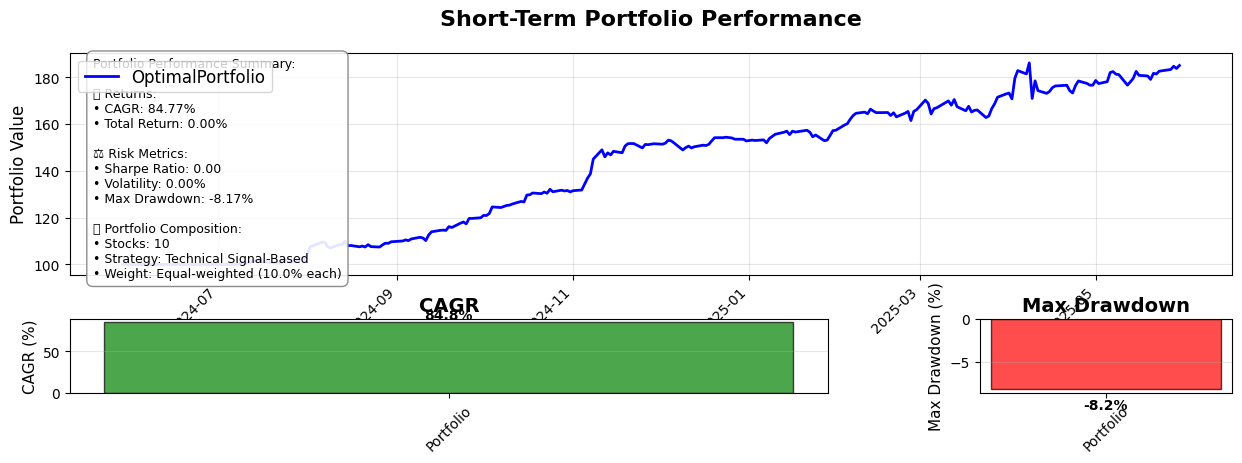


📈 Strategy Signals by Ticker (Included in Portfolio Only):
📋 Included tickers: ['mrna', 'ual', 'gev', 'alb', 'fi', 'axon', 'cme', 'cnp', 'gild', 'nvr']
📊 Plotting 10 tickers that passed the 10% CAGR threshold


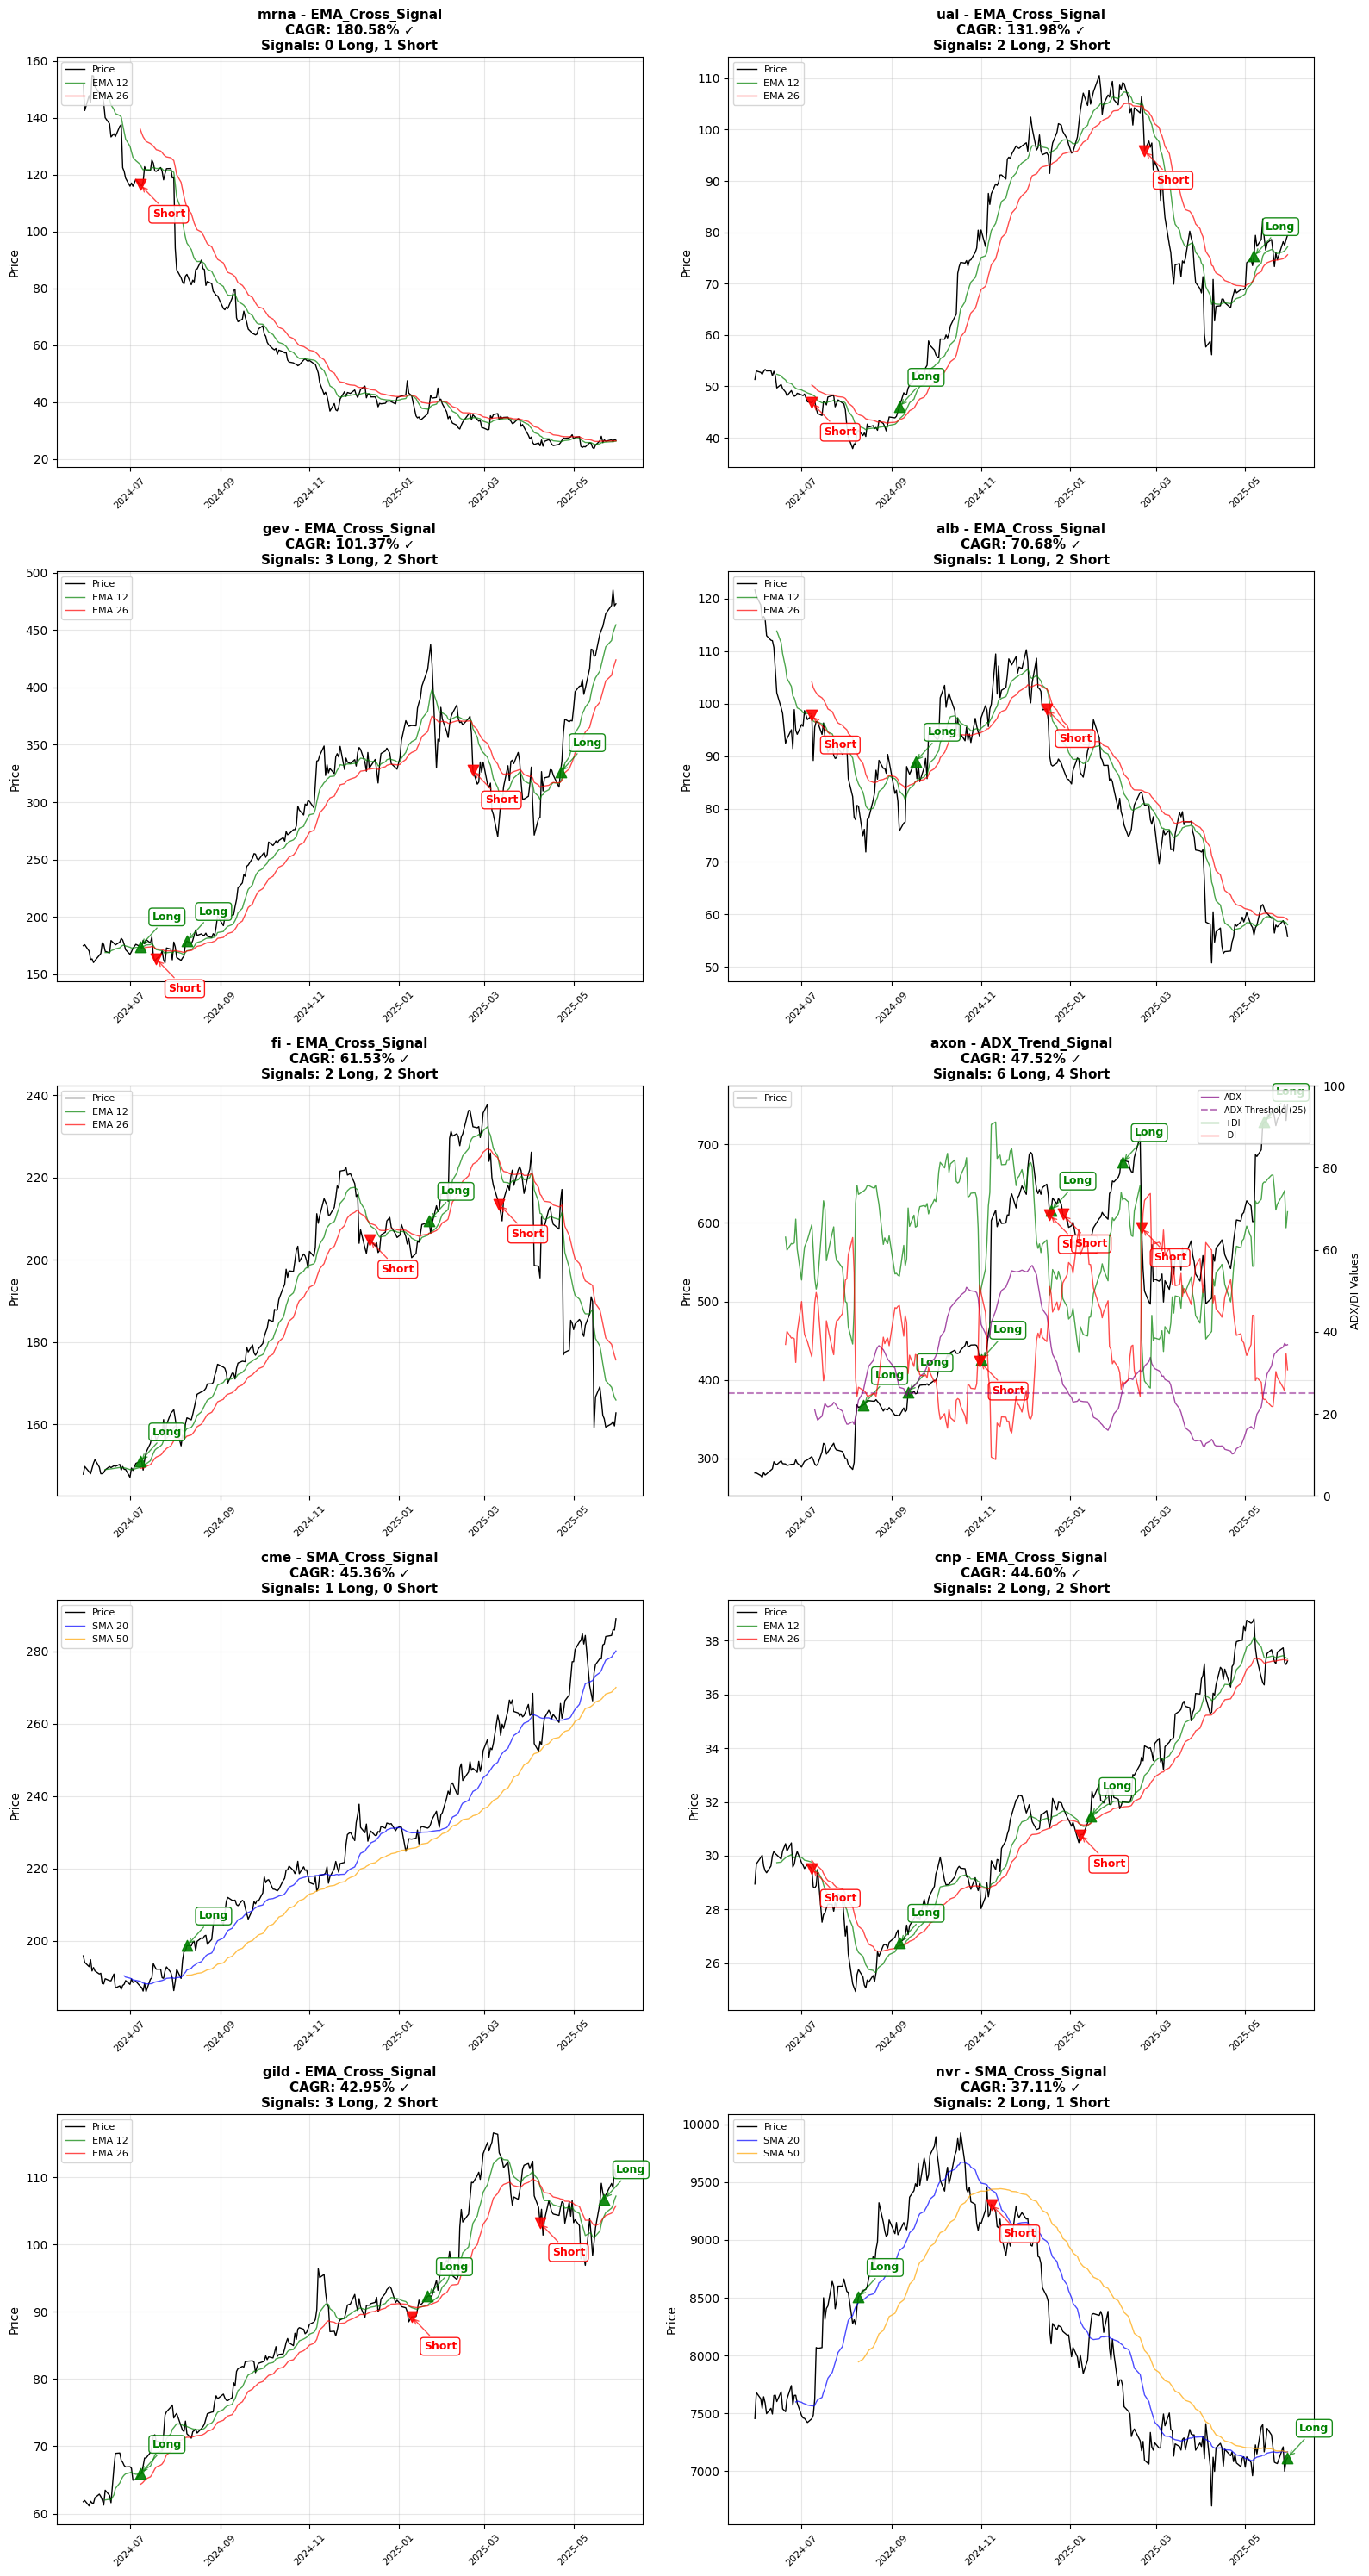


✅ Chart generation complete!


In [13]:
def plot_ticker_signals_with_annotations(quotes, trading_signals, technical_indicators, best_strategies, included_tickers):
    """Plot individual ticker charts with signals and technical indicators for included tickers only"""
    if not included_tickers:
        print("❌ No tickers available for plotting (none passed the CAGR threshold)")
        return
    
    print(f"📊 Plotting {len(included_tickers)} tickers that passed the 10% CAGR threshold")
    
    # Calculate grid dimensions - max 2 columns
    cols = min(2, len(included_tickers))
    rows = (len(included_tickers) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 6*rows))
    if len(included_tickers) == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    axes_flat = axes.flatten() if len(included_tickers) > 1 else axes
    
    for idx, ticker in enumerate(included_tickers):
        if idx >= len(axes_flat):
            break
            
        ax = axes_flat[idx]
        
        try:
            # Get data
            price_data = quotes[ticker].dropna()
            indicators = technical_indicators[ticker]
            signals = trading_signals[ticker]
            best_strategy = best_strategies.get(ticker, {}).get('strategy', 'SMA_Cross_Signal')
            
            # Plot price
            ax.plot(price_data.index, price_data.values, label='Price', color='black', linewidth=1)
            
            # Plot strategy-specific indicators only
            if best_strategy == 'SMA_Cross_Signal':
                # SMA Strategy: Show SMA 20 and SMA 50
                if 'SMA_20' in indicators.columns:
                    ax.plot(indicators.index, indicators['SMA_20'], label='SMA 20', alpha=0.7, linewidth=1, color='blue')
                if 'SMA_50' in indicators.columns:
                    ax.plot(indicators.index, indicators['SMA_50'], label='SMA 50', alpha=0.7, linewidth=1, color='orange')
                    
            elif best_strategy == 'EMA_Cross_Signal':
                # EMA Strategy: Show EMA 12 and EMA 26
                if 'EMA_12' in indicators.columns:
                    ax.plot(indicators.index, indicators['EMA_12'], label='EMA 12', alpha=0.7, linewidth=1, color='green')
                if 'EMA_26' in indicators.columns:
                    ax.plot(indicators.index, indicators['EMA_26'], label='EMA 26', alpha=0.7, linewidth=1, color='red')
                    
            elif best_strategy == 'ADX_Trend_Signal':
                # ADX Strategy: Show ADX line and DI lines
                if 'ADX' in indicators.columns:
                    ax2 = ax.twinx()  # Create secondary y-axis for ADX indicators
                    ax2.plot(indicators.index, indicators['ADX'], label='ADX', alpha=0.7, linewidth=1, color='purple')
                    ax2.axhline(y=25, color='purple', linestyle='--', alpha=0.5, label='ADX Threshold (25)')
                    if 'PLUS_DI' in indicators.columns:
                        ax2.plot(indicators.index, indicators['PLUS_DI'], label='+DI', alpha=0.7, linewidth=1, color='green')
                    if 'MINUS_DI' in indicators.columns:
                        ax2.plot(indicators.index, indicators['MINUS_DI'], label='-DI', alpha=0.7, linewidth=1, color='red')
                    ax2.set_ylabel('ADX/DI Values', fontsize=9)
                    ax2.legend(fontsize=7, loc='upper right')
                    ax2.set_ylim(0, 100)
                    
            elif best_strategy == 'RSI_Signal':
                # RSI Strategy: Show RSI line with overbought/oversold levels
                if 'RSI_14' in indicators.columns:
                    ax2 = ax.twinx()  # Create secondary y-axis for RSI
                    ax2.plot(indicators.index, indicators['RSI_14'], label='RSI 14', alpha=0.7, linewidth=1, color='purple')
                    ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
                    ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
                    ax2.set_ylabel('RSI Values', fontsize=9)
                    ax2.legend(fontsize=7, loc='upper right')
                    ax2.set_ylim(0, 100)
            
            # Plot signals with annotations - ONLY AT CROSSOVER POINTS
            if best_strategy in signals.columns:
                strategy_signals = signals[best_strategy]
                
                # Find signal changes (crossover points)
                signal_changes = strategy_signals.diff()
                
                # Buy signals: signal changes from 0 or -1 to 1
                buy_crossovers = signal_changes[(signal_changes > 0) & (strategy_signals == 1)]
                
                # Sell signals: signal changes from 0 or 1 to -1
                sell_crossovers = signal_changes[(signal_changes < 0) & (strategy_signals == -1)]
                
                # Plot buy signals with "Long" annotations (only at crossover points)
                for date in buy_crossovers.index:
                    if date in price_data.index:
                        price = price_data[date]
                        # Plot the marker
                        ax.scatter(date, price, color='green', marker='^', s=80, alpha=0.9, zorder=5)
                        # Add "Long" annotation
                        ax.annotate('Long', xy=(date, price), 
                                  xytext=(10, 20), textcoords='offset points',
                                  fontsize=9, fontweight='bold', color='green',
                                  ha='left', va='bottom',
                                  bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                           edgecolor='green', alpha=0.9),
                                  arrowprops=dict(arrowstyle='->', color='green', alpha=0.7))
                
                # Plot sell signals with "Short" annotations (only at crossover points)
                for date in sell_crossovers.index:
                    if date in price_data.index:
                        price = price_data[date]
                        # Plot the marker
                        ax.scatter(date, price, color='red', marker='v', s=80, alpha=0.9, zorder=5)
                        # Add "Short" annotation
                        ax.annotate('Short', xy=(date, price), 
                                  xytext=(10, -20), textcoords='offset points',
                                  fontsize=9, fontweight='bold', color='red',
                                  ha='left', va='top',
                                  bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                           edgecolor='red', alpha=0.9),
                                  arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))
                
                # Add signal count information
                num_buy_signals = len(buy_crossovers)
                num_sell_signals = len(sell_crossovers)
                signal_info = f"Signals: {num_buy_signals} Long, {num_sell_signals} Short"
            
            # Get CAGR for this ticker
            cagr = best_strategies.get(ticker, {}).get('cagr', 0)
            
            # Formatting with CAGR and signal count in title
            title_text = f'{ticker} - {best_strategy}\nCAGR: {cagr:.2%} ✓'
            if 'signal_info' in locals():
                title_text += f'\n{signal_info}'
            
            ax.set_title(title_text, fontsize=11, weight='bold')
            ax.set_ylabel('Price', fontsize=10)
            ax.legend(fontsize=8, loc='upper left')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error plotting {ticker}\n{str(e)}', 
                   ha='center', va='center', transform=ax.transAxes,
                   bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    
    # Hide unused subplots
    for idx in range(len(included_tickers), len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def add_bar_values(bars, data):
    """Helper function to add value labels on bars"""
    for bar, value in zip(bars, data):
        height = bar.get_height()
        bar.axes.text(bar.get_x() + bar.get_width()/2, height + (0.5 if height >= 0 else -1),
                     f'{value:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', 
                     fontweight='bold', fontsize=10)

def create_bar_chart(ax, data, labels, title, ylabel, colors=['blue', 'red']):
    """Helper function to create standardized bar charts"""
    bars = ax.bar(labels, data, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_ylabel(ylabel, fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)
    add_bar_values(bars, data)
    return bars

def plot_portfolio_performance():
    """Plot portfolio performance chart using the backtest results"""
    try:
        if 'analysis_results' in globals() and 'portfolio_result' in analysis_results:
            portfolio_result = analysis_results['portfolio_result']
            
            fig = plt.figure(figsize=(28, 22))
            gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[3, 1], 
                                 hspace=0.3, wspace=0.3)
            ax_main = fig.add_subplot(gs[0, :])
            
            # Main line chart - Portfolio performance over time
            try:
                # Extract portfolio performance data
                portfolio_name = portfolio_result.stats.columns[0]
                portfolio_data = portfolio_result[portfolio_name]
                
                # Calculate cumulative returns
                portfolio_returns = (portfolio_data / portfolio_data.iloc[0] - 1) * 100
                
                # Plot portfolio performance
                portfolio_returns.plot(ax=ax_main, label='Short-Term Portfolio', color='blue', linewidth=2)
                ax_main.set_ylabel('Portfolio Return (%)', fontsize=12)
                
            except Exception as e1:
                # Fallback for different bt result structures
                try:
                    portfolio_result.plot(ax=ax_main, label='Short-Term Portfolio', color='blue', linewidth=2)
                    ax_main.set_ylabel('Portfolio Value', fontsize=12)
                except Exception as e2:
                    ax_main.text(0.5, 0.5, f'Chart unavailable\nError: {str(e2)}', ha='center', va='center', 
                                transform=ax_main.transAxes, fontsize=14, 
                                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
            
            # Format main chart
            ax_main.set_title('Short-Term Portfolio Performance', fontsize=16, weight='bold', pad=20)
            ax_main.set_xlabel('Date', fontsize=12)
            ax_main.grid(True, alpha=0.3)
            ax_main.legend(fontsize=12, loc='upper left')
            ax_main.tick_params(axis='x', rotation=45)
            
            # Bar charts for key metrics (only CAGR and Max Drawdown)
            try:
                portfolio_stats = analysis_results['portfolio_stats']
                
                # CAGR Chart (left bottom)
                create_bar_chart(fig.add_subplot(gs[1, 0]), 
                                [portfolio_stats['cagr'] * 100], 
                                ['Portfolio'], 'CAGR', 'CAGR (%)', colors=['green'])
                
                # Max Drawdown Chart (right bottom)
                create_bar_chart(fig.add_subplot(gs[1, 1]), 
                                [portfolio_stats['max_drawdown'] * 100], 
                                ['Portfolio'], 'Max Drawdown', 'Max Drawdown (%)', colors=['red'])
                
                # Add comprehensive metrics text box
                included_tickers = analysis_results.get('included_tickers', [])
                num_stocks = len(included_tickers)
                
                metrics_text = f"""Portfolio Performance Summary:
                
📈 Returns:
• CAGR: {portfolio_stats['cagr']:.2%}
• Total Return: {portfolio_stats['total_return']:.2%}

⚖️ Risk Metrics:
• Sharpe Ratio: {portfolio_stats['sharpe_ratio']:.2f}
• Volatility: {portfolio_stats['volatility']:.2%}
• Max Drawdown: {portfolio_stats['max_drawdown']:.2%}

🎯 Portfolio Composition:
• Stocks: {num_stocks}
• Strategy: Technical Signal-Based
• Weight: Equal-weighted ({100/num_stocks:.1f}% each)"""
                
                ax_main.text(0.02, 0.98, metrics_text, transform=ax_main.transAxes, va='top', fontsize=9,
                            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
                
            except Exception as e:
                print(f"Could not add metrics: {e}")
                # Show basic info if detailed metrics fail
                for i, (title, color) in enumerate(zip(['CAGR', 'Max Drawdown'], 
                                                      ['green', 'red'])):
                    ax = fig.add_subplot(gs[1, i])
                    ax.text(0.5, 0.5, f'{title}\nData Unavailable', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12,
                           bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
            
            plt.tight_layout(pad=2.0)
            plt.show()
            
        else:
            print("Portfolio results not available for plotting")
            
    except Exception as e:
        print(f"Error creating portfolio performance plot: {e}")

# ===============================================================================
# CHART GENERATION
# ===============================================================================

print("📊 Generating Portfolio Charts...")

# Portfolio Performance Chart
print("\n📈 Portfolio Performance:")
try:
    # Check if plot_portfolio_performance function exists
    if 'plot_portfolio_performance' in globals():
        plot_portfolio_performance()
    else:
        print("plot_portfolio_performance function not found - skipping")
except Exception as e:
    print(f"Error plotting portfolio performance: {e}")

# Individual Ticker Signal Charts - Only for Included Tickers
try:
    print("\n📈 Strategy Signals by Ticker (Included in Portfolio Only):")
    if (quotes is not None and trading_signals and technical_indicators and 
        'best_strategies' in analysis_results and 'included_tickers' in analysis_results):
        
        included_tickers = analysis_results['included_tickers']
        
        if included_tickers:
            print(f"📋 Included tickers: {included_tickers}")
            plot_ticker_signals_with_annotations(quotes, trading_signals, technical_indicators, 
                                               analysis_results['best_strategies'], included_tickers)
        else:
            print("⚠️ No tickers passed the CAGR threshold - no charts to display")
    else:
        print("⚠️ Missing required data for strategy plots")
        print(f"  - Quotes available: {quotes is not None}")
        print(f"  - Trading signals available: {bool(trading_signals)}")
        print(f"  - Technical indicators available: {bool(technical_indicators)}")
        print(f"  - Best strategies available: {'best_strategies' in analysis_results}")
        print(f"  - Included tickers available: {'included_tickers' in analysis_results}")
        
        # Fallback: show what included_tickers contains
        if 'included_tickers' in analysis_results:
            print(f"  - Included tickers count: {len(analysis_results['included_tickers'])}")
except Exception as e:
    print(f"Error plotting strategy signals: {e}")

print("\n✅ Chart generation complete!")

### Step 11: Plot the Portfolio Weights

In [14]:
# Calculate industry weights
industry_df = pd.DataFrame({
    'Ticker': filtered_tickers,
    'Weight': filtered_weights,
    'Sector': [fundamentals_df.loc[ticker, 'Sector'] for ticker in filtered_tickers]
})
sector_weights = industry_df.groupby('Sector')['Weight'].sum()
industries = sector_weights.index.tolist()
weights = sector_weights.values.tolist()

NameError: name 'filtered_tickers' is not defined

In [ ]:
# Plot asset allocation
plot_portfolio_weights(
    filtered_tickers, 
    filtered_weights,
    'Portfolio Weight Allocation (By Asset)', 
    'Assets',
    metrics=[
        ('Sharpe Ratio', optimal_sharpe_ratio, 4, False),
        ('Expected Return', optimal_portfolio_return, 2, True),
        ('Expected Volatility', optimal_portfolio_volatility, 2, True)
    ],
    rotation=0,
    show_constraints=True,
    max_allocation_weight=max_allocation_weight,
    max_assets=max_assets,
    max_asset_per_sector=max_asset_per_sector
)

# Plot sector allocation
plot_portfolio_weights(
    industries, 
    weights,
    'Portfolio Weight Allocation (By Sector)', 
    'Industries',
    metrics=[
        ('Sharpe Ratio', optimal_sharpe_ratio, 4, False),
        ('Expected Return', optimal_portfolio_return, 2, True),
        ('Expected Volatility', optimal_portfolio_volatility, 2, True)
    ],
    rotation=45,
    show_constraints=True,
    max_allocation_weight=max_allocation_weight,
    max_assets=max_assets,
    max_asset_per_sector=max_asset_per_sector
)

### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [ ]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = daily_prices_df[filtered_tickers].join(daily_risk_free_df, how='inner')

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

#### Export DataFrame to Excel

In [ ]:
# Create a single Excel file with multiple sheets
with pd.ExcelWriter(output_file) as writer:
    # Each DataFrame goes to a different sheet
    optimal_portfolio_df.to_excel(writer, sheet_name='equity')

    # Export daily_quotes
    daily_prices_df_merged.to_excel(writer, sheet_name='daily_quotes')

    # Export daily_quotes
    monthly_prices_df_merged.to_excel(writer, sheet_name='monthly_quotes')

    # Export daily_quotes
    monthly_prices_df_merged.to_excel(writer, sheet_name='monthly_quotes')

    # Export risk_free
    last_risk_free_df.to_excel(writer, sheet_name='risk_free')